<a href="https://colab.research.google.com/github/chemoinformatics-lecture/lecture-beginner/blob/main/lesson06_scikit-learn/RandomForestRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 行うこと

- ライブラリーの読み込みとバージョンの確認
- データの読み込みと加工
- トレーニングデータとテストデータの分割 train_test_split
- 学習:  model.fit()
- 結果の確認 model.predict()
- 重要度解析
- その他に検討する項目

# ライブラリーの読み込みとバージョンの確認

In [1]:
#rdkitのインストール
!pip install rdkit==2022.03.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 10.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, PandasTools
print(rdBase.rdkitVersion)

2022.03.5


# ファイルのダウンロード

In [3]:
!wget 'http://modem.ucsd.edu/adme/data/databases/logS/data_set.dat'

--2023-11-03 04:40:36--  http://modem.ucsd.edu/adme/data/databases/logS/data_set.dat
Resolving modem.ucsd.edu (modem.ucsd.edu)... 132.239.68.159
Connecting to modem.ucsd.edu (modem.ucsd.edu)|132.239.68.159|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52906 (52K) [text/plain]
Saving to: ‘data_set.dat’

data_set.dat        100%[===================>]  51.67K  87.3KB/s    in 0.6s    

2023-11-03 04:40:37 (87.3 KB/s) - ‘data_set.dat’ saved [52906/52906]



In [4]:
# データの読み込み
df = pd.read_csv('data_set.dat', sep='\t', header=None, names = ["smiles", "CAS", "logS"])

In [5]:
df

,smiles,CAS,logS
0,O=C(C)N,60-35-5,1.58
1,NNC,60-34-4,1.34
2,O=C(C)O,64-19-7,1.22
3,N1CCCC1,123-75-1,1.15
4,O=C(N)NO,127-07-1,1.12
...,...,...,...
1285,Clc1c(c2c(ccc(Cl)c2Cl)Cl)c(ccc1Cl)Cl,38411-22-2,-8.65
1286,c1c2c(ccc3c2cccc3)cc2c1ccc1ccccc12,53-70-3,-8.66
1287,c1c2c3cccc4ccc5ccc6c(c2c(cc6)cc1)c5c43,191-24-2,-9.03
1288,Clc1c(Cl)c(c2cc(c(c(Cl)c2Cl)Cl)Cl)c(c(c1Cl)Cl)Cl,40186-72-9,-10.26


In [6]:
PandasTools.AddMoleculeColumnToFrame(df, "smiles")

,smiles,CAS,logS,ROMol
0,O=C(C)N,60-35-5,1.58,
1,NNC,60-34-4,1.34,
2,O=C(C)O,64-19-7,1.22,

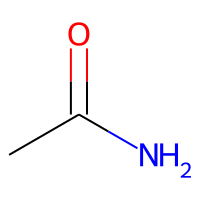
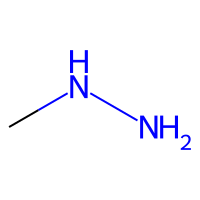
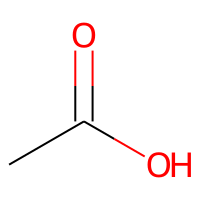

In [7]:
df.head(3)

# データの確認と加工 (finger printの作成)

In [8]:
# 欠損状態があるかを確認
df.isnull().sum()

smiles    0
CAS       0
logS      0
ROMol     1
dtype: int64

In [9]:
# 欠損状態になっているデータの行を削除する。
df = df.dropna(subset=['ROMol'], axis=0)
# 欠損がなくなっているかを確認
df.isnull().sum()

smiles    0
CAS       0
logS      0
ROMol     0
dtype: int64

In [10]:
# indexを振り直し
df = df.reset_index()

In [11]:
import numpy as np

fingerprints = []
safe = []
for mol_idx, mol in enumerate(df["ROMol"]):
    try:
        fingerprint = [x for x in AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)]
        fingerprints.append(fingerprint)
        safe.append(mol_idx)

    except:
        print("Error", mol_idx)
        continue
fingerprints = np.array(fingerprints)
print(fingerprints.shape)
df_fp = pd.DataFrame(fingerprints)

(1289, 2048)


,index,smiles,CAS,logS,ROMol,0,1,2,3,4,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,O=C(C)N,60-35-5,1.58,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,NNC,60-34-4,1.34,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,O=C(C)O,64-19-7,1.22,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,N1CCCC1,123-75-1,1.15,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,O=C(N)NO,127-07-1,1.12,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,1285,Clc1c(c2c(ccc(Cl)c2Cl)Cl)c(ccc1Cl)Cl,38411-22-2,-8.65,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1285,1286,c1c2c(ccc3c2cccc3)cc2c1ccc1ccccc12,53-70-3,-8.66,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1286,1287,c1c2c3cccc4ccc5ccc6c(c2c(cc6)cc1)c5c43,191-24-2,-9.03,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1287,1288,Clc1c(Cl)c(c2cc(c(c(Cl)c2Cl)Cl)Cl)c(c(c1Cl)Cl)Cl,40186-72-9,-10.26,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0

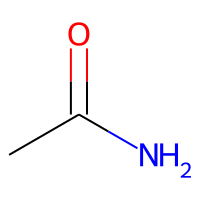
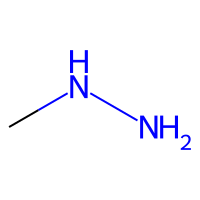
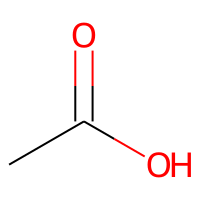
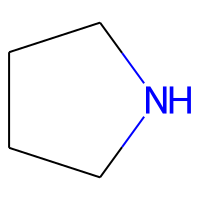
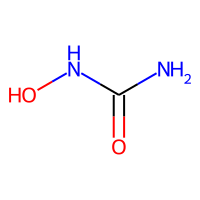
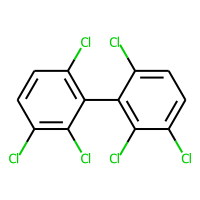
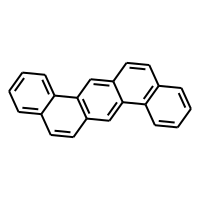
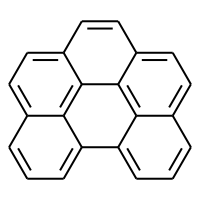
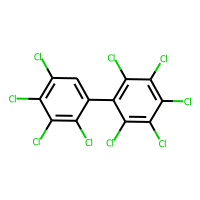
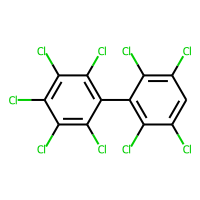

In [28]:
df_comb = pd.merge(df, df_fp, left_index=True, right_index=True)
df_comb

# トレーニングデータとテストデータの分割

In [13]:
X = df_fp

In [14]:
y = df['logS']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 10)


In [16]:
X_train = X_train.sort_index()
X_train

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X_test = X_test.sort_index()
X_test

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1256,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
y_train = y_train.sort_index()
y_train

0        1.58
1        1.34
2        1.22
3        1.15
4        1.12
        ...  
1283    -8.60
1284    -8.65
1285    -8.66
1286    -9.03
1287   -10.26
Name: logS, Length: 1160, dtype: float64

In [19]:
y_test = y_test.sort_index()
y_test

7        1.10
11       1.07
31       0.57
35       0.48
43       0.32
        ...  
1249    -5.46
1253    -5.80
1254    -5.89
1256    -6.02
1288   -10.41
Name: logS, Length: 129, dtype: float64

# 学習と結果の表示

In [20]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth = 100, n_estimators = 500, n_jobs = -1, random_state = 100)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, n_estimators=500, n_jobs=-1,
                      random_state=100)

In [21]:
# 学習結果を用いて値を予想する。
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

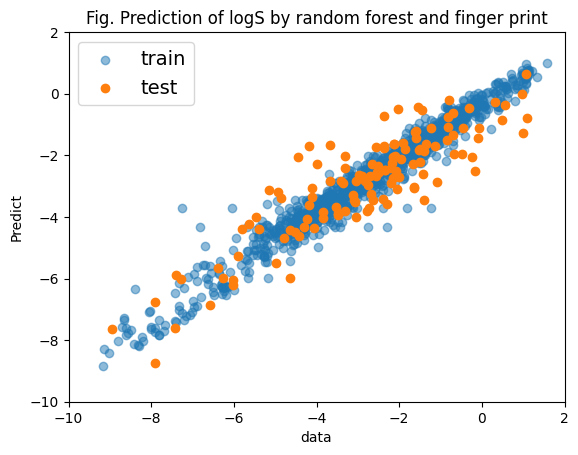

In [22]:
# グラフ作成をmatplotlibで行う
import matplotlib.pyplot as plt

# 得られた学習結果と実験値とを比較する。
plt.figure()

# トレーニングデータのプロット
x１ = y_train.astype(float)
y1 = y_pred_train.astype(float)

plt.scatter(x1, y1, alpha=0.5, label="train") # alphaを入れると薄くなる。

# テストデータのプロット
x2 = y_test.astype(float)
y2 = y_pred_test.astype(float)

plt.scatter(x2, y2, label="test")

# 範囲の指定
plt.xlim(-10, 2)
plt.ylim(-10, 2)

# タイトルを入れる。
plt.title("Fig. Prediction of logS by random forest and finger print")

# X軸とY軸にラベルを作成
plt.xlabel('data')
plt.ylabel('Predict')

# 凡例の場所を指定
plt.legend(loc="upper left", fontsize=14)

# 表示させる
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# MAE（Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred_test)
print(f'mae:{mae:.4f}')
# MAPE(Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print(f'mape:{mape:.4f}')
# SMAPE(Symmetric Mean Absolute Percentage Error)
smape = 100/len(y_test) * np.sum(2 * np.abs(y_pred_test - y_test) / (np.abs(y_pred_test) + np.abs(y_test)))
print(f'smape:{smape:.4f}')
# mse (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred_test)
print(f'mse:{mse:.4f}')
# rmse (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f'rmse: {rmse:.4f}')
# R2
score2 = r2_score(y_test, y_pred_test)
print("R2", score2)

mae:0.7408
mape:78.2388
smape:40.8542
mse:0.9188
rmse: 0.9585
R2 0.794712452048112


# 重要度解析

,feature,feature_importance
561,561,1.493933e-01
1087,1087,6.362906e-02
807,807,4.151840e-02
1380,1380,3.856461e-02
1143,1143,3.366034e-02
...,...,...
1806,1806,2.521278e-08
1559,1559,1.128242e-08
765,765,9.253885e-09
369,369,5.562046e-09


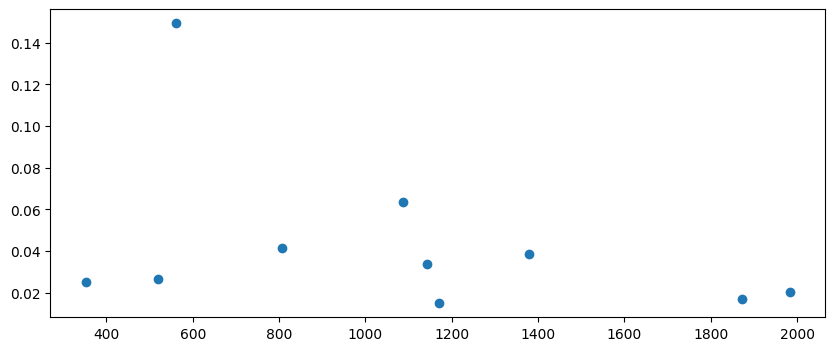

In [24]:
# 重要度を出力する。
fi_rf = model.feature_importances_
features_rf = pd.DataFrame({'feature': list(X_train.columns),
                            'feature_importance': fi_rf[:]}).sort_values('feature_importance', ascending = False)
features_rf = features_rf[features_rf['feature_importance'] != 0]

# 図を出力
plt.rcParams["figure.figsize"] = [10,4] # 出力される図の大きさを変える
plt.scatter(features_rf.iloc[:10, :].feature, features_rf.iloc[:10, :].feature_importance);

# 表を出力する。
features_rf

[[<Axes: title={'center': 'logS'}>]]
[[<Axes: title={'center': 'logS'}>]]


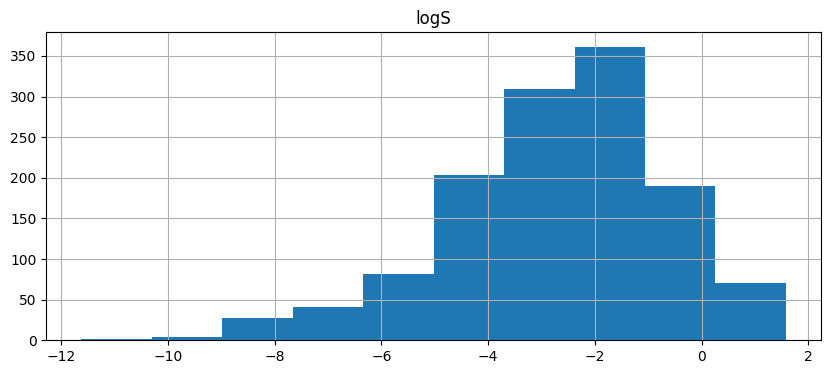

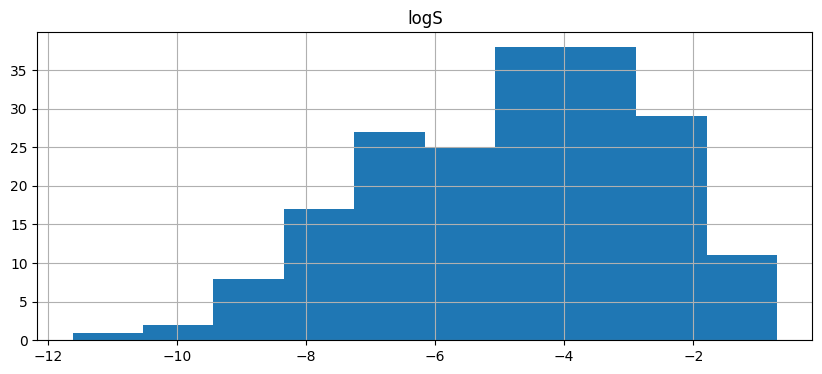

In [25]:
# 上が全体のlogSのヒストグラム
print(df_comb.hist("logS"))
# 下がfinger printで561を有するもののヒストグラム
print(df_comb[df_comb[561] == 1].hist("logS"))

196


,index,smiles,CAS,logS,ROMol,0,1,2,3,4,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
121,121,c1c(O)ccc(c1)Cl,106-48-9,-0.7,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0

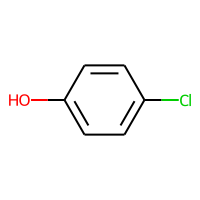

In [26]:
# finger printの５６１を有する構造を表示してみる。
finger_print_number = 561
# finger_print_numberが1である行数を表示
print(len(df_comb[df_comb[finger_print_number] == 1]))
# データの一行目を表示
df_comb[df_comb[finger_print_number] == 1].head(1)

2048 17
17


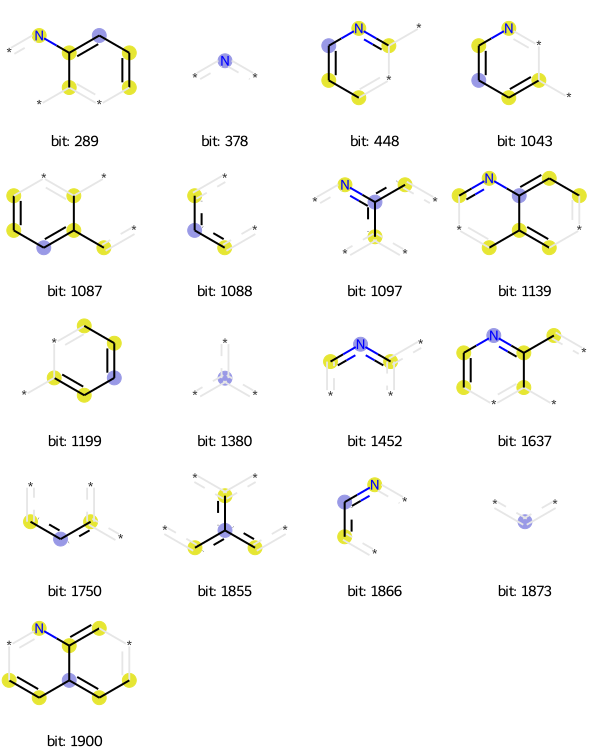

In [27]:
# ライブラリーのインポート
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display
from IPython.display import Image

# 特定のsmilesを有する構造を表示してみる。
smiles = "c1c2ccc[nH0]c2ccc1"
compound = Chem.MolFromSmiles(smiles)
bitI_morgan = {}
fp_morgan = AllChem.GetMorganFingerprintAsBitVect(compound, 2, bitInfo=bitI_morgan)
print(fp_morgan.GetNumBits(),fp_morgan.GetNumOnBits())
print(len(bitI_morgan))

morgan_turples = ((compound , bit, bitI_morgan) for bit in list(bitI_morgan.keys()))
Draw.DrawMorganBits(morgan_turples, molsPerRow=4, legends=['bit: '+str(x) for x in list(bitI_morgan.keys())])

# 学習結果から考えることや検討項目など

1. 化合物の表現方法として、フィンガープリント以外にもさまざまな「化学構造記述子」がある。

2. 機械学習手法として、ランダムフォレスト以外にも色々な手法がある。

3. パラメータ調節方法として、グリッドサーチやベイズ最適化などの方法がある。

4. 機械学習で注意すべき点として「過学習」という現象があり、それを防ぐための方法論として「交差検定」などがある。検定方法にも複数種類がある。

5. 外れ値の検証などを行いモデルの精度を高める。

6. 重要だった指標の可視化などを行い解釈性を高める。